# Using Random Forests to Classify All-NBA Teams
Author: Chris Kendall

Website: [www.chriskdata.com](www.chriskdata.com)

- This model seeks to predict the probability of a given player to make one of the All-NBA teams (1st, 2nd, 3rd), or none at all.

- Three All-NBA teams (of 5 players each) have been selected each year since the 1988-89 season. These are players that the qualified voters regard as the best NBA players during the regular season. (i.e. playoff performance does not weigh into the decision process).

- The classification model is a random forest, which is an ensemble model composed of multiple decision trees.
- This model uses a one-vs-all classification approach, meaning a binary classifier is fit for each possible class label. Such that each classifier only makes a prediction on a data point belonging to one class (opposed to predicting one of the multiple classes simultaneously).

- There are four classes in this dataset (No All-NBA, 1st All-NBA team, 2nd All-NBA team, 3rd All-NBA team)

- NB: Going forward, any discussion of a particular NBA season will be referred to by the year in which the season ended (i.e 2018 season refers to the October 2017 - April 2018 NBA regular season).

## Importing Data and Preprocessing
- From www.basketball-reference.com I collected Per Game and Advanced stats for each player in every NBA season from the 1989 season to the most recent season (As of the time of this writing, *recent* refers to the 2018 season). 

- I put most of the stats for each year into one table, and added columns for ("Year") and a multiclass label column **("All_NBA")** to indicate All-NBA selection (range of values \[0: no All-NBA,1: First team, 2: Second team, 3: Third team])

- I already did most of the feature engineering when I created the dataset.
    - I elected to preserve as many rows as possible from the raw data.
    - Instead of replacing missing values, I excluded those features if a null value was meaningful. (For example, it does not make sense to fill in a null 3P% (with a mean, median, or mode) for a row because a null indicates that player did not attempt any 3-pointers, therefore they *can not possibly* have a 3P%).
    - Most shooting percentages have been excluded for this reason. Effective Field Goal Percentage (**"eFG%"**) and True Shooting Percentage (**TS%**) remain because these metrics account for multiple ways a player can score and are more resistant to a player not attempting a particular type of shot.
    
- For more detail on the columns in the dataset, please consult the README in the Github repository for this project.

In [1]:
# Import relevant Python packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
# Read dataset of past 30 NBA seasons
dataset = pd.read_csv("nba_1989_thru_2018.csv")

When I originally created the class labels in the dataset I intended to use a multiclass classification approach. However, in response to some limitations of that model, I adopted the one-vs-all approach and found more success. 

As such, one-vs-all requires a column of binary (0,1) labels for each class.

In [3]:
# Set of original multiclass labels
dataset["All_NBA"].unique()

array([0., 1., 2., 3.])

In [4]:
# Create new class labels
n = len(dataset) # number of rows in entire dataset

# Initialize labels for All-NBA teams, 1st, 2nd, 3rd, or none as arrays of zeros
no_team = n * [0]
first_team = n * [0]
second_team = n * [0]
third_team = n * [0]

In [5]:
# Confirm "All_NBA" column of dataset corresponds to column at position 0
dataset.iloc[0, 0] == dataset.loc[0, "All_NBA"]

True

In [6]:
# Assign class labels
for i in range(n): # iterate through rows of dataset
    orig_label = dataset.iloc[i,0] # original label of dataset
    
    # Assign new binary labels based on original multiclass labels
    # Upon assignment, no change to labels for other classes b/c default is 0.
    if orig_label == 0.0: # no all-nba team selection
        no_team[i] = 1
        
    elif orig_label == 1.0: # all-nba first team
        first_team[i] = 1
        
    elif orig_label == 2.0: # all-nba second team
        second_team[i] = 1
        
    else: # all-nba third team
        third_team[i] = 1

# Append new label columns to the dataset
dataset['No_All_NBA'] = no_team
dataset['1st_All_NBA'] = first_team
dataset['2nd_All_NBA'] = second_team
dataset['3rd_All_NBA'] = third_team

In [7]:
# subset of columns to view
view1 = ["Player", "Tm", "Year","All_NBA", "No_All_NBA", "1st_All_NBA", "2nd_All_NBA", "3rd_All_NBA"]

Let's take a look at the most recent All-NBA teams to see how they appear with the new labels.

In [8]:
# Confirm new labels correspond to original labels
dataset.loc[((dataset["Year"]==2018) & (dataset["All_NBA"] > 0)), view1]

,Player,Tm,Year,All_NBA,No_All_NBA,1st_All_NBA,2nd_All_NBA,3rd_All_NBA
12663,LaMarcus Aldridge\aldrila01,SAS,2018,2.0,0,0,1,0
12672,Giannis Antetokounmpo\antetgi01,MIL,2018,2.0,0,0,1,0
12735,Jimmy Butler\butleji01,MIN,2018,3.0,0,0,0,1
12776,Stephen Curry\curryst01,GSW,2018,3.0,0,0,0,1
12778,Anthony Davis\davisan02,NOP,2018,1.0,0,1,0,0
12786,DeMar DeRozan\derozde01,TOR,2018,2.0,0,0,1,0
12799,Kevin Durant\duranke01,GSW,2018,1.0,0,1,0,0
12803,Joel Embiid\embiijo01,PHI,2018,2.0,0,0,1,0
12829,Paul George\georgpa01,OKC,2018,3.0,0,0,0,1
12850,James Harden\hardeja01,HOU,2018,1.0,0,1,0,0


## Split Dataset into Training, Test sets

We will not train the classifiers on the entire dataset. We need to set aside some data apart from the training set so we can evaluate how well predictions are made on data it has not seen before.

We will use the 1989-2017 seasons for a random split into the training and test sets.

Let's set aside the 2018 season data as a holdout/validation set to see a prediction made on a non-random set.

In [9]:
# Filter previous seasons to use for training/test sets
past_seasons = dataset.loc[dataset["Year"] != 2018, :]

In [10]:
# Boolean filter for previous seasons
past = list(dataset.loc[dataset["Year"]!=2018,:].index)

# Use 2018 season as validation dataset
recent_season = dataset.copy()
recent_season.drop(past, axis=0, inplace=True)

Filter features to use for the model.

In [11]:
features = list(dataset.columns) # Extract list of column names from original dataset

# Remove attributes that will not be used in the model
for col_name in view1:
    features.remove(col_name)

In [12]:
print(features)

['Pos', 'Age', 'G', 'GS', 'MP/G', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PS/G', 'MP_season', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']


## Create Training and Test Sets for each Classifier
As we are using a classifier for each class, we need to create training/test sets for each.

In [13]:
# Convert to numpy arrays for model input
X = past_seasons[features].values # Feature variables

#y = past_seasons["All_NBA"].values # Target variable (class labels)
y0 = past_seasons["No_All_NBA"].values
y1 = past_seasons["1st_All_NBA"].values
y2 = past_seasons["2nd_All_NBA"].values
y3 = past_seasons["3rd_All_NBA"].values

In [14]:
# Split feature, target variables into training and test sets
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y0, random_state = 0, stratify=y0)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, random_state = 0, stratify=y1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, random_state = 0, stratify=y2)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y3, random_state = 0, stratify=y3)

## Random Forest Classifiers and Cross Validation
For each classification, the classifier will be a collection of 100 shallow decision trees (max_depth=2).

In [15]:
# initiate Random Forest Classifer
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0, max_depth=2, 
                             class_weight="balanced_subsample")

Let's calculate cross validation scores for each to see how well we can expect predictions to be made on data it has not seen before.

In [16]:
# Calculate cross validation score for each classifer
scores0 = cross_val_score(clf, X_train0, y_train0, cv=5)

scores1 = cross_val_score(clf, X_train1, y_train1, cv=5)

scores2 = cross_val_score(clf, X_train2, y_train2, cv=5)

scores3 = cross_val_score(clf, X_train3, y_train3, cv=5)


In [17]:
# No All-NBA team model
print("Accuracy: %0.2f (+/- %0.2f)" % (scores0.mean(), scores0.std() * 2))

# 1st All-NBA team model
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

# 2nd All-NBA team model
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

# 3rd All-NBA team model
print("Accuracy: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

Accuracy: 0.93 (+/- 0.01)
Accuracy: 0.96 (+/- 0.01)
Accuracy: 0.93 (+/- 0.01)
Accuracy: 0.90 (+/- 0.02)


We can reasonably expect the models to predict with accuracy in the low to mid 90s.

In [18]:
# list training/test sets for iteration
X_training_sets = [X_train0, X_train1, X_train2, X_train3]
y_training_sets = [y_train0, y_train1, y_train2, y_train3]

X_test_sets = [X_test0, X_test1, X_test2, X_test3]
y_test_sets = [y_test0, y_test1, y_test2, y_test3]

Iteratively fit and score models

In [19]:
targets = view1[-4:]
#important_list = []
pred_prob_list = [] # list to store arrays of prediction probabilities

features_2018 = recent_season[features].values # holdout set features

for i in range(len(X_training_sets)):
    clf.fit(X_training_sets[i], y_training_sets[i])
    score = clf.score(X_test_sets[i], y_test_sets[i])
    print("Test set score: ",score)
    
    #important = clf.feature_importances_ # list of feature importances
    #important_list.append(important)
    
    labels_2018 = recent_season[targets[i]].values # holdout set targets (labels)
    
    score = clf.score(features_2018, labels_2018)
    
    print("Validation set score: ", score)
    print(" ")
    
    # Numpy array of prediction probabilities
    prob = clf.predict_proba(recent_season[features])
    
    # Extract number of rows
    n = np.shape(prob)[0]
    
    # Append probabilities to list
    pred_prob_list.append(prob)


Test set score:  0.9308056872037914
Validation set score:  0.9608938547486033
 
Test set score:  0.9560821484992101
Validation set score:  0.9664804469273743
 
Test set score:  0.9241706161137441
Validation set score:  0.9534450651769087
 
Test set score:  0.8941548183254344
Validation set score:  0.9273743016759777
 


## Plotting Feature Importance
Let's see which features were of greatest importance to the classifier.

In [20]:
xvals = range(len(features))

In [21]:
important = clf.feature_importances_ # list of feature importances
indices = np.argsort(important)
features_sorted = []

# assign elements in order of sorted indices
for i in range(len(indices)):
    features_sorted.append(features[indices[i]])

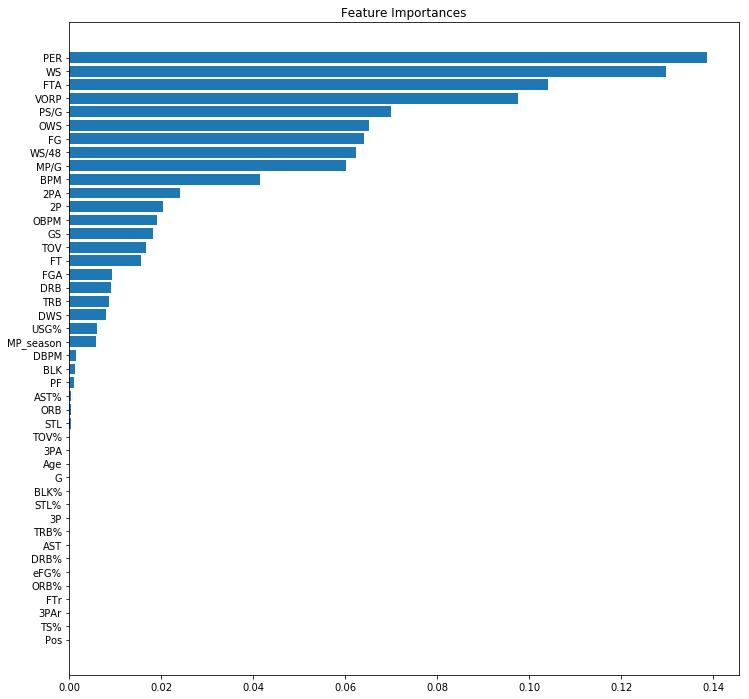

In [22]:
fig = plt.figure(figsize=[12,12])
plt.title("Feature Importances")
plt.barh(xvals, important[indices], tick_label=features_sorted)

# Save the figure
plt.savefig('all_nba_feat_importance.png')
plt.show()

We can see that the most important features to the decision were **PER (Player Efficiency Rating), WS (Win Shares), FTA (Free Throw Attempts), and VORP (Value Over Relacement Player)**. After VORP, importance begins to drop off sharply.

## Extract the Prediction Probabilities
Next, let's extract the prediction probabilities and put them into a table. The classifier assigns labels based on which class has the highest probability. As there can only be five players for each All-NBA team, we will find the players with the highest predicted probability for each class to see what the model determined as its most likely All-NBA teams. This is necessary because we cannot explicitly tell the model to only label 5 rows for each year for each All-NBA team.

In [23]:
# lists of predictions
prob_no_team = []
prob_1st_team = []
prob_2nd_team = []
prob_3rd_team = []

# iterate thru probability arrays
for i in range(len(pred_prob_list)): # iterate thru elements of pred_prob_list
    n = np.shape(pred_prob_list[i])[0]
    for j in range(n): # iterate thru rows of numpy array of probs
        if i == 0:
            prob_no_team.append(pred_prob_list[i][j][1])
        elif i == 1:
            prob_1st_team.append(pred_prob_list[i][j][1])
        elif i == 2:
            prob_2nd_team.append(pred_prob_list[i][j][1])
        else:
            prob_3rd_team.append(pred_prob_list[i][j][1])

In [24]:
# append prediction probabilities to validatation dataset
recent_season["Prob_no_All_NBA"] = prob_no_team
recent_season["Prob_1st_All_NBA"] = prob_1st_team
recent_season["Prob_2nd_All_NBA"] = prob_2nd_team
recent_season["Prob_3rd_All_NBA"] = prob_3rd_team

In [25]:
# Clean up player names: remove codes from raw data
players2018 = list(recent_season["Player"])

for i in range(len(players2018)):
    players2018[i] = players2018[i].split("\\")[0]
    
recent_season["Player"] = players2018

In [26]:
view2 = ["Player", "Year", "Tm","All_NBA", "Prob_no_All_NBA", "Prob_1st_All_NBA", "Prob_2nd_All_NBA", "Prob_3rd_All_NBA"]

In [27]:
# compare actual teams with their prediction percentages
recent_season.loc[recent_season["All_NBA"] >0, view2]

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
12663,LaMarcus Aldridge,2018,SAS,2.0,0.070232,0.864908,0.891660,0.888467
12672,Giannis Antetokounmpo,2018,MIL,2.0,0.046252,0.961560,0.932940,0.900488
12735,Jimmy Butler,2018,MIN,3.0,0.074091,0.855430,0.915791,0.886513
12776,Stephen Curry,2018,GSW,3.0,0.079388,0.815899,0.762314,0.864429
12778,Anthony Davis,2018,NOP,1.0,0.048903,0.945231,0.928983,0.900488
12786,DeMar DeRozan,2018,TOR,2.0,0.090254,0.520710,0.901121,0.897059
12799,Kevin Durant,2018,GSW,1.0,0.052370,0.933975,0.925633,0.893620
12803,Joel Embiid,2018,PHI,2.0,0.274116,0.487005,0.748596,0.837585
12829,Paul George,2018,OKC,3.0,0.138014,0.581537,0.809378,0.876665
12850,James Harden,2018,HOU,1.0,0.055710,0.952823,0.899904,0.893155


In [28]:
pred2018 = recent_season[view2].copy()

## Predictions with replacement

In [29]:
pred2018.sort_values("Prob_1st_All_NBA", ascending=False, inplace=False).head(10)

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
12672,Giannis Antetokounmpo,2018,MIL,2.0,0.046252,0.961560,0.932940,0.900488
12904,LeBron James,2018,CLE,1.0,0.045010,0.955634,0.932940,0.900488
12850,James Harden,2018,HOU,1.0,0.055710,0.952823,0.899904,0.893155
12778,Anthony Davis,2018,NOP,1.0,0.048903,0.945231,0.928983,0.900488
12954,Damian Lillard,2018,POR,1.0,0.055710,0.938221,0.918649,0.893155
12799,Kevin Durant,2018,GSW,1.0,0.052370,0.933975,0.925633,0.893620
13136,Karl-Anthony Towns,2018,MIN,3.0,0.075931,0.925298,0.876509,0.895534
12895,Kyrie Irving,2018,BOS,0.0,0.078890,0.888280,0.862594,0.888492
13161,Russell Westbrook,2018,OKC,2.0,0.051715,0.880078,0.930232,0.900488
12919,Nikola Jokic,2018,DEN,0.0,0.082149,0.871675,0.832525,0.887725


In [30]:
pred2018.sort_values("Prob_2nd_All_NBA", ascending=False, inplace=False).head(10)

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
12904,LeBron James,2018,CLE,1.0,0.045010,0.955634,0.932940,0.900488
12672,Giannis Antetokounmpo,2018,MIL,2.0,0.046252,0.961560,0.932940,0.900488
13161,Russell Westbrook,2018,OKC,2.0,0.051715,0.880078,0.930232,0.900488
12778,Anthony Davis,2018,NOP,1.0,0.048903,0.945231,0.928983,0.900488
12799,Kevin Durant,2018,GSW,1.0,0.052370,0.933975,0.925633,0.893620
12954,Damian Lillard,2018,POR,1.0,0.055710,0.938221,0.918649,0.893155
12735,Jimmy Butler,2018,MIN,3.0,0.074091,0.855430,0.915791,0.886513
12786,DeMar DeRozan,2018,TOR,2.0,0.090254,0.520710,0.901121,0.897059
12850,James Harden,2018,HOU,1.0,0.055710,0.952823,0.899904,0.893155
12663,LaMarcus Aldridge,2018,SAS,2.0,0.070232,0.864908,0.891660,0.888467


In [31]:
pred2018.sort_values("Prob_3rd_All_NBA", ascending=False, inplace=False).head(10)

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
12672,Giannis Antetokounmpo,2018,MIL,2.0,0.046252,0.961560,0.932940,0.900488
12904,LeBron James,2018,CLE,1.0,0.045010,0.955634,0.932940,0.900488
12778,Anthony Davis,2018,NOP,1.0,0.048903,0.945231,0.928983,0.900488
13161,Russell Westbrook,2018,OKC,2.0,0.051715,0.880078,0.930232,0.900488
12786,DeMar DeRozan,2018,TOR,2.0,0.090254,0.520710,0.901121,0.897059
13035,Victor Oladipo,2018,IND,3.0,0.083504,0.837232,0.889304,0.896025
13136,Karl-Anthony Towns,2018,MIN,3.0,0.075931,0.925298,0.876509,0.895534
12799,Kevin Durant,2018,GSW,1.0,0.052370,0.933975,0.925633,0.893620
12954,Damian Lillard,2018,POR,1.0,0.055710,0.938221,0.918649,0.893155
12850,James Harden,2018,HOU,1.0,0.055710,0.952823,0.899904,0.893155


Many of the same candidates appear for each class. Let's see what the teams look like if we remove names already selected.

## Predictions without replacement

In [32]:
pred2018.sort_values("Prob_1st_All_NBA", ascending=False, inplace=False).head(5)

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
12672,Giannis Antetokounmpo,2018,MIL,2.0,0.046252,0.961560,0.932940,0.900488
12904,LeBron James,2018,CLE,1.0,0.045010,0.955634,0.932940,0.900488
12850,James Harden,2018,HOU,1.0,0.055710,0.952823,0.899904,0.893155
12778,Anthony Davis,2018,NOP,1.0,0.048903,0.945231,0.928983,0.900488
12954,Damian Lillard,2018,POR,1.0,0.055710,0.938221,0.918649,0.893155


The model correctly predicted 4/5 correct members of the 2018 All-NBA First Team.

Going forward, there will be some overlap in candidates by percentage. Any players with high values for "Prob_2nd_All_NBA" that were not already used in the First Team prediction will go to the Second Team.

In [33]:
# store indices of predicted all-nba first team
first = list(pred2018.sort_values("Prob_1st_All_NBA", ascending=False, inplace=False).head(5).index)

In [34]:
# Exclude predicted first team
pred2018.drop(first, axis=0, inplace=True)

In [35]:
pred2018.sort_values("Prob_2nd_All_NBA", ascending=False, inplace=False).head()

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
13161,Russell Westbrook,2018,OKC,2.0,0.051715,0.880078,0.930232,0.900488
12799,Kevin Durant,2018,GSW,1.0,0.052370,0.933975,0.925633,0.893620
12735,Jimmy Butler,2018,MIN,3.0,0.074091,0.855430,0.915791,0.886513
12786,DeMar DeRozan,2018,TOR,2.0,0.090254,0.520710,0.901121,0.897059
12663,LaMarcus Aldridge,2018,SAS,2.0,0.070232,0.864908,0.891660,0.888467


The model correctly predicted 3/5 members of the All-NBA Second Team.

In [36]:
# store indices of predicted all-nba second team
second = list(pred2018.sort_values("Prob_2nd_All_NBA", ascending=False, inplace=False).head(5).index)

In [37]:
# Exclude predicted second team
pred2018.drop(second, axis=0, inplace=True)

In [38]:
pred2018.sort_values("Prob_3rd_All_NBA", ascending=False, inplace=False).head()

,Player,Year,Tm,All_NBA,Prob_no_All_NBA,Prob_1st_All_NBA,Prob_2nd_All_NBA,Prob_3rd_All_NBA
13035,Victor Oladipo,2018,IND,3.0,0.083504,0.837232,0.889304,0.896025
13136,Karl-Anthony Towns,2018,MIN,3.0,0.075931,0.925298,0.876509,0.895534
13150,Kemba Walker,2018,CHO,0.0,0.100023,0.612304,0.871462,0.888814
12895,Kyrie Irving,2018,BOS,0.0,0.078890,0.888280,0.862594,0.888492
12919,Nikola Jokic,2018,DEN,0.0,0.082149,0.871675,0.832525,0.887725


Of the remaining candidates, only 2/5 of the All-NBA Third Team were correctly predicted.

Without replacement, across the three All-NBA teams a total of 9/15 players were correctly predicted.

# Next steps
- I would like to periodically make predictions throughout the upcoming 2019 season to see who the most likely members of the All-NBA teams.
- I pursued this project so I could learn about random forests in the process. I am open to constructive criticism and suggestions as to ways to optimize the model or different ways to approach the problem.